In [1]:
import requests
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Task 1

In [2]:
# Task 1-1


r = requests.get("https://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
with open("movie.zip", "wb") as f:
  f.write(r.content)
zipfile.ZipFile("movie.zip").extractall()

rating_data = pd.read_csv("/content/ml-latest-small/ratings.csv")

train, test = train_test_split(rating_data, test_size = 0.2, random_state = 1013)

In [3]:
# Task 1-2

def str_to_set(x):
  group = set(x.strip().split("|"))
  return group

movie_data = pd.read_csv("/content/ml-latest-small/movies.csv")

movie_data.genres = movie_data.genres.apply(str_to_set)

movie_data

,movieId,title,genres
0,1,Toy Story (1995),"{Fantasy, Adventure, Comedy, Animation, Children}"
1,2,Jumanji (1995),"{Fantasy, Adventure, Children}"
2,3,Grumpier Old Men (1995),"{Romance, Comedy}"
3,4,Waiting to Exhale (1995),"{Romance, Drama, Comedy}"
4,5,Father of the Bride Part II (1995),{Comedy}
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"{Fantasy, Comedy, Action, Animation}"
9738,193583,No Game No Life: Zero (2017),"{Fantasy, Comedy, Animation}"
9739,193585,Flint (2017),{Drama}
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"{Action, Animation}"


In [4]:
# Task 1-3

def str_to_set_comma(x):
  group = set(x.strip().split(","))
  return group

tags_data = pd.read_csv("/content/ml-latest-small/tags.csv")
tag_group = pd.DataFrame(tags_data.groupby('movieId')['tag'].apply(lambda x : "%s" % ', '.join(x)))
tag_group.tag = tag_group.tag.apply(str_to_set)

tag_group

,tag
movieId,
1,"{pixar, pixar, fun}"
2,"{fantasy, magic board game, Robin Williams, game}"
3,"{moldy, old}"
5,"{pregnancy, remake}"
7,{remake}
...,...
183611,"{Comedy, funny, Rachel McAdams}"
184471,"{adventure, Alicia Vikander, video game adapta..."
187593,"{Josh Brolin, Ryan Reynolds, sarcasm}"


# Task 2

In [5]:
# Task 2

import torch
import torch.nn.functional as F

ratings = torch.FloatTensor(train['rating'])
items = torch.LongTensor(train['movieId'])
users = torch.LongTensor(train['userId'])

ratings_test = torch.FloatTensor(test['rating'].to_numpy())
items_test = torch.LongTensor(test['movieId'].to_numpy())
users_test = torch.LongTensor(test['userId'].to_numpy())

rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.randn(numItems, rank, requires_grad = True)
Q = torch.randn(numUsers, rank, requires_grad = True)

lambda_P = 0.0001
lambda_Q = 0.0001

lambda_R = 0.001
lambda_S = 0.001

bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr= 0.1)
for epoch in range(1001):
  hypothesis = torch.sum(P[items] * Q[users], dim= 1) + mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(hypothesis ,ratings)
  loss = cost + lambda_P * torch.sum(P ** 2) + lambda_Q * torch.sum(Q ** 2) + lambda_R * torch.sum(bias_item ** 2) + lambda_S * torch.sum(bias_user ** 2)
  rsme = cost ** 0.5
  
  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim = 1)
    cost_test = F.mse_loss(hypo_test, ratings_test)
    test_rsme = cost_test ** 0.5

  optimizer.zero_grad()
  loss.backward() 
  optimizer.step()

  if epoch % 100 == 0:
    print("epoch: {}, cost: {:.6f}, Train RMSE: {:.6f}, Test RMSE: {:.6f}" .format(epoch, cost.item(), rsme.item(), test_rsme.item()))

epoch: 0, cost: 12.802355, Train RMSE: 3.578038, Test RMSE: 4.789443
epoch: 100, cost: 0.445596, Train RMSE: 0.667530, Test RMSE: 3.536391
epoch: 200, cost: 0.419625, Train RMSE: 0.647784, Test RMSE: 3.533070
epoch: 300, cost: 0.412358, Train RMSE: 0.642151, Test RMSE: 3.534505
epoch: 400, cost: 0.409393, Train RMSE: 0.639838, Test RMSE: 3.535313
epoch: 500, cost: 0.408158, Train RMSE: 0.638872, Test RMSE: 3.535689
epoch: 600, cost: 0.407543, Train RMSE: 0.638391, Test RMSE: 3.535927
epoch: 700, cost: 0.407210, Train RMSE: 0.638130, Test RMSE: 3.536007
epoch: 800, cost: 0.406999, Train RMSE: 0.637964, Test RMSE: 3.535973
epoch: 900, cost: 0.406830, Train RMSE: 0.637832, Test RMSE: 3.536027
epoch: 1000, cost: 0.406765, Train RMSE: 0.637781, Test RMSE: 3.536278


# Task 3

In [33]:
# Task 3 - 1
rating_data = rating_data[ ['userId', 'movieId', 'rating']]
final_rating_data = pd.merge(rating_data, movie_data, how = 'inner')
final_rating_data = pd.merge(final_rating_data, tag_group, on = 'movieId', how = 'inner')

matrix = final_rating_data.pivot_table(index= 'userId', columns='title', values='rating')
matrix = matrix.fillna(0)
recommend_matrix = matrix.transpose().fillna(0)

recommend_matrix_similarity = cosine_similarity(recommend_matrix, recommend_matrix)
recommend_matrix_similarity_data = pd.DataFrame(index = matrix.columns, columns = matrix.columns, data =recommend_matrix_similarity)

recommend_matrix_similarity_data # 영화간의 유사도

def pred_rate(rating, similarity):
  predict_rating = rating.dot(similarity) / np.array([np.abs(similarity).sum(axis = 1)])
  return predict_rating

user_pred = pred_rate(matrix.values, recommend_matrix_similarity_data.values)

user_pred_matrix = pd.DataFrame(index= matrix.index, columns = matrix.columns, data = user_pred)
user_514_pred_rating = user_pred_matrix.loc[514].sort_values(ascending = False)[:20]
user_514_pred_rating = pd.DataFrame(user_514_pred_rating)
user_514_pred_rating = user_514_pred_rating.drop([user_514_pred_rating.columns[0]], axis = 1)

user_514_pred_rating

""
title
Friday the 13th Part V: A New Beginning (1985)
Tomb Raider (2018)
Jumanji: Welcome to the Jungle (2017)
Deadpool 2 (2018)
Friday the 13th Part VI: Jason Lives (1986)
"War of the Worlds, The (1953)"
Friday the 13th Part 3: 3D (1982)
Now You See Me (2013)
Billabong Odyssey (2003)


In [51]:
# Task 3 - 2

matrix = final_rating_data.pivot_table(index = 'userId', columns = 'title', values = 'rating')

user_514 = final_rating_data[final_rating_data['userId'] == 514]
user_514 = user_514[(user_514['rating'] == 5.0)]

def jaccard_similarity(s1, s2):
  if len(s1 | s2) == 0:
    return 0
  return len(s1 & s2) / len(s1 | s2)

def pearson_similarity(u1, u2):
  u1_c = u1 - u1.mean()
  u2_c = u2 - u2.mean()
  denom = np.sqrt(np.sum(u1_c ** 2) * np.sum(u2_c ** 2))

  if denom != 0:
    return np.sum(u1_c * u2_c) / denom
  else:
    return 0

def find_similar_movies (input_title , matrix, n, alpha):
  input_meta = final_rating_data.loc[final_rating_data['title'] == input_title].iloc[0]
  input_set = input_meta.genres | input_meta.tag

  result = []

  for this_title in matrix.columns:
    if this_title == input_title:
      continue
    this_meta = final_rating_data.loc[final_rating_data['title'] == this_title].iloc[0]
    this_set = this_meta.genres | this_meta.tag

    pearson = pearson_similarity(matrix[this_title], matrix[input_title])
    jaccard = jaccard_similarity(this_set, input_set)

    score = alpha * pearson + (1-alpha) * jaccard
    result.append( (this_title, score) )

  result.sort(key= lambda r: r[1], reverse= True)

  return result[:n]

matrix = matrix.fillna(0)


for i in user_514['title']:
  result = find_similar_movies(i, matrix, 5, 0.3)
  print(i)
  predict_data = pd.DataFrame(result, columns = ['title', 'score'])
  final_predict_data = pd.merge(predict_data, movie_data[['title','movieId']])
  print(final_predict_data)
  print("===========================================================")


Star Wars: Episode IV - A New Hope (1977)
                                               title     score  movieId
0  Star Wars: Episode V - The Empire Strikes Back...  0.641870     1196
1  Star Wars: Episode VI - Return of the Jedi (1983)  0.624880     1210
2   Star Wars: Episode I - The Phantom Menace (1999)  0.558735     2628
3  Star Wars: Episode III - Revenge of the Sith (...  0.542687    33493
4                                       X-Men (2000)  0.532102     3793
Silence of the Lambs, The (1991)
                 title     score  movieId
0      Identity (2003)  0.398773     6323
1        Psycho (1960)  0.363428     1219
2       Copycat (1995)  0.349591       22
3  Pulp Fiction (1994)  0.339224      296
4   Poltergeist (1982)  0.338346     1994
Star Wars: Episode V - The Empire Strikes Back (1980)
                                               title     score  movieId
0          Star Wars: Episode IV - A New Hope (1977)  0.641870      260
1  Star Wars: Episode VI - Return of the Je

In [6]:
# 중복 행 제거

new_rating_data = pd.read_csv("/content/ml-latest-small/ratings.csv")

new_rating_data = new_rating_data.drop_duplicates(['userId'])

new_train, new_test = train_test_split(new_rating_data, test_size = 0.2, random_state = 33)

new_items = torch.LongTensor(new_rating_data['movieId'])
new_numItems = new_items.max() + 1
new_P = torch.randn(new_numItems, rank, requires_grad = True)  # P행렬

new_users = torch.LongTensor(new_rating_data['userId'])
new_numUsers = users.max() + 1
new_Q = torch.randn(numUsers, rank, requires_grad = True)

# =======================================================================

In [ ]:
# Task 4 - 1

Y_cost = []

new_P2 = new_P.detach().numpy()
new_P2 = cosine_similarity(new_P2)

new_P2

for k in range(1, 41):
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(new_P2)
  cost = kmeans.inertia_
  
  Y_cost.append(cost)

  print("k : {} , cost : {}".format(k, cost))

k : 1 , cost : 667807.75
k : 2 , cost : 614082.25
k : 3 , cost : 577890.9375
k : 4 , cost : 549874.3125
k : 5 , cost : 528407.625
k : 6 , cost : 510822.5
k : 7 , cost : 496277.15625
k : 8 , cost : 484433.5625
k : 9 , cost : 473511.375
k : 10 , cost : 462969.25
k : 11 , cost : 453638.4375
k : 12 , cost : 446009.34375
k : 13 , cost : 438282.4375
k : 14 , cost : 432045.34375
k : 15 , cost : 424905.125
k : 16 , cost : 418576.5625
k : 17 , cost : 412917.1875
k : 18 , cost : 408137.25
k : 19 , cost : 402176.9375
k : 20 , cost : 398709.9375
k : 21 , cost : 394287.21875
k : 22 , cost : 389577.6875
k : 23 , cost : 385840.5
k : 24 , cost : 381532.0625
k : 25 , cost : 377302.75
k : 26 , cost : 374506.59375
k : 27 , cost : 371307.625
k : 28 , cost : 369086.84375
k : 29 , cost : 365252.75
k : 30 , cost : 361813.0625
k : 31 , cost : 359283.75
k : 32 , cost : 356566.03125
k : 33 , cost : 352969.25
k : 34 , cost : 351576.4375
k : 35 , cost : 348418.0625
k : 36 , cost : 346207.25
k : 37 , cost : 344644

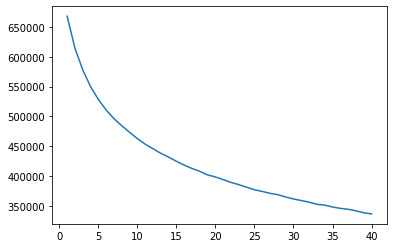

In [ ]:
# Task 4 - 2

plt.plot(range(1,41), Y_cost)
plt.show()

# k = 3 ~ 4

In [ ]:
# Task 4 - 3

result2 = find_similar_movies('Avengers: Infinity War - Part I (2018)', matrix, 20, 0.3)
result2

[('Thor: Ragnarok (2017)', 0.6527898184748566),
 ('Guardians of the Galaxy 2 (2017)', 0.5940507882662722),
 ('Doctor Strange (2016)', 0.5814990474851554),
 ('Fantastic Four: Rise of the Silver Surfer (2007)', 0.5408815716041403),
 ('Green Lantern (2011)', 0.5179278470742343),
 ('Guardians of the Galaxy (2014)', 0.5174498967141805),
 ('Fantastic Four (2005)', 0.485193915379155),
 ('Solo: A Star Wars Story (2018)', 0.4806076605709504),
 ('Star Wars: Episode III - Revenge of the Sith (2005)', 0.4781594395362804),
 ('Deadpool 2 (2018)', 0.47298975407166677),
 ('Batman v Superman: Dawn of Justice (2016)', 0.46748672209584763),
 ('X-Men (2000)', 0.467008867925329),
 ('Serenity (2005)', 0.4667308995334585),
 ('Hulk (2003)', 0.46617199265888726),
 ('Star Wars: Episode IV - A New Hope (1977)', 0.44993451711349053),
 ('Star Wars: Episode VI - Return of the Jedi (1983)', 0.44934814605236134),
 ('Star Wars: Episode V - The Empire Strikes Back (1980)',
  0.44636536328803406),
 ('Tron: Legacy (2010)

In [7]:
# Task 5 - 1

Z = torch.cat([new_P,new_Q], dim = 0)

Z.shape


torch.Size([3191, 10])

In [31]:
# Task 5 - 2

Zp = pd.DataFrame(Z.detach().numpy())

Zp = StandardScaler().fit_transform(Zp)

pca = PCA(n_components = 2)
printcipalComponents = pca.fit_transform(Zp)
Zp = pd.DataFrame(data=printcipalComponents, columns = ['data1', 'data2'])

Zp


,data1,data2
0,-0.563720,0.006902
1,0.882456,0.322993
2,-0.259218,0.142373
3,0.475185,0.491545
4,0.197178,1.330096
...,...,...
3186,-1.146109,0.533179
3187,-1.646394,0.908995
3188,0.368443,0.583656
3189,0.931052,-0.522976


# Task 5 - 3

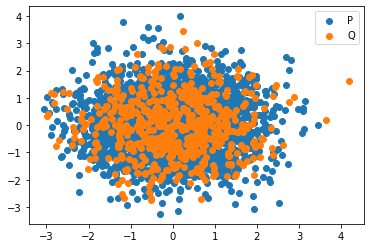

In [30]:
# Task 5 - 3 - 1

new_P_sc = pd.DataFrame(new_P.detach().numpy())

new_P_sc = StandardScaler().fit_transform(new_P_sc)

pca = PCA(n_components = 2)
printcipalComponents = pca.fit_transform(new_P_sc)
new_P_sc = pd.DataFrame(data=printcipalComponents, columns = ['data1', 'data2'])

new_Q_sc = pd.DataFrame(new_Q.detach().numpy())

new_Q_sc = StandardScaler().fit_transform(new_Q_sc)

pca = PCA(n_components = 2)
printcipalComponents = pca.fit_transform(new_Q_sc)
new_Q_sc = pd.DataFrame(data=printcipalComponents, columns = ['data1', 'data2'])

plt.scatter('data1', 'data2', data = new_P_sc, label = 'P')
plt.scatter('data1', 'data2', data = new_Q_sc, label = 'Q')
plt.legend()
plt.show()

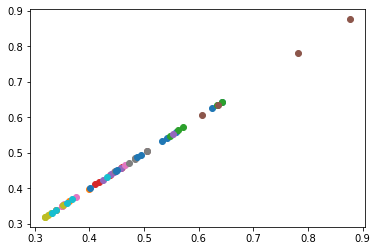

In [66]:
# Task 5 - 3 - 2

for i in user_514['title']:
  result = find_similar_movies(i, matrix, 5, 0.3)
  predict_data = pd.DataFrame(result, columns = ['title', 'score'])
  
  plt.scatter(predict_data['score'], predict_data['score'])

plt.show()